In [1]:
import ipyplot

In [2]:
ipyplot.plot_images(["MarinCounty-Vegetation-CanopyCover-2020-Summer-00010m.tiff"],img_width=500)

In [3]:
from PIL import Image
import IPython.display as dsp
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd

In [4]:
# res = 10 # TIFF resolution in meters
# dd = res*39/12 # image resolution in feet
# box = {"N":38.317511, "S":37.816952, "E":-122.372121, "W":-123.024393}
# print('size:',data.shape)

def get_values(specs,p0,p1):
    img = Image.open("MarinCounty-Vegetation-CanopyCover-2020-Summer-00010m.tiff")
    data = np.array(img)
    x0 = int((p0["lon"]-box["W"])/(box["E"]-box["W"])*data.shape[0])
    y0 = int((p0["lat"]-box["N"])/(box["S"]-box["N"])*data.shape[1])
    x1 = int((p1["lon"]-box["W"])/(box["E"]-box["W"])*data.shape[0])
    y1 = int((p1["lat"]-box["N"])/(box["S"]-box["N"])*data.shape[1])
    dx = x1-x0
    dy = y1-y0
    s = 0.0
    n = 0
    zz = []
    tt = []
    if abs(dx) > abs(dy): # iterate over x
        y = y0
        r = dy/dx
        for x in range(x0,x1+1,np.sign(dx)):
            zz.append(data[int(x),int(y)])
            tt.append(np.sqrt((x0-x)*(x0-x)+(y0-y)*(y0-y))*dd)
            y += r
    else: # iterate over y
        x = x0
        r = dx/dy
        for y in range(y0,y1+1,np.sign(dy)):
            zz.append(data[int(x),int(y)])
            tt.append(np.sqrt((x0-x)*(x0-x)+(y0-y)*(y0-y))*dd)
            x += r
    d = round(np.sqrt(dx*dx+dy*dy)*dd) # distance in feet
    zz = np.array(zz)
    t = np.array(tt)
    z = list(map(lambda x:float(x/res/res),list(map(interp1d(t,zz),np.arange(tt[0],tt[-1],1.0)))))
    return {
        "from" : p0,
        "to" :p1,
        "min":zz.min(),
        "max":zz.max(),
        "avg":np.round(zz.mean(),1),
        "std":np.round(zz.std(),1),
        "len":d,
        "t" : np.arange(tt[0],tt[-1],1.0),
        "z": np.array(z),
    }


In [5]:
res = 10 # TIFF resolution in meters
dd = res*39/12 # image resolution in feet
box = {"N":38.317511, "S":37.816952, "E":-122.372121, "W":-123.024393}
#print('size:',data.shape)

result = get_values("MarinCounty-Vegetation-CanopyCover-2020-Summer-00010m.tiff",{"lat":38.131435, "lon":-122.740464},{"lat":38.110846, "lon":-122.724984})
img = Image.open("MarinCounty-Vegetation-CanopyCover-2020-Summer-00010m.tiff")
data = np.array(img)
print(result)

{'from': {'lat': 38.131435, 'lon': -122.740464}, 'to': {'lat': 38.110846, 'lon': -122.724984}, 'min': 1, 'max': 84, 'avg': 14.4, 'std': 25.1, 'len': 8990, 't': array([0.000e+00, 1.000e+00, 2.000e+00, ..., 8.988e+03, 8.989e+03,
       8.990e+03]), 'z': array([0.79      , 0.79026918, 0.79053836, ..., 0.01      , 0.01      ,
       0.01      ])}


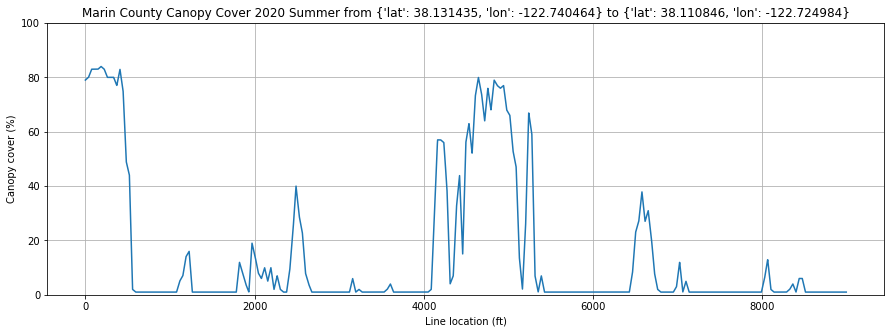

In [6]:
import matplotlib.pyplot as plt
plt.figure(1,figsize=(15,5))
plt.plot(result["t"],result["z"]*100)
plt.xlabel('Line location (ft)')
plt.ylabel('Canopy cover (%)')
plt.ylim([0,100])
plt.grid()
plt.title(f"Marin County Canopy Cover 2020 Summer from {result['from']} to {result['to']}")
plt.show()

In [7]:
result['t']

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 8.988e+03, 8.989e+03,
       8.990e+03])

In [8]:
df = pd.DataFrame(data=result['t'], columns= ['t'])

In [9]:
df['z'] = pd.DataFrame(data=result['z'], columns= ['z'])

In [10]:
df.to_csv("output.csv",index=False)

In [11]:
import pandas as pd

In [12]:
df = pd.read_csv('TMY3-SF.csv')
# Hourly wind speed
wspd = df['Wspd (m/s)']
wspd.head()

0    0.0
1    2.1
2    2.1
3    1.5
4    3.1
Name: Wspd (m/s), dtype: float64

In [47]:
# Vegetation contact

# # V: wind speed - From TMY3
# V = 1
# # d: line diameter in m
# d = 1
# # beta: line windage coefficient
# beta = 1

F_w = d*beta*V^2

# w: line weight
w = 1

# t: line location
# y : observed line sag (for now just assume it to be 1m)



# T1: temperature(degC); A: conductor area(m^2); H: horizontal tension(need to be given)(N); S: span length(m); W: conductor unit weight(N/m)
# E: modulous of elasticity(Pa)

T1 = 15
H1 = 15450
A = 0.0004029
S = 300
W1 = 10.89
E = 58.9*10**9

# Total conductor length
L1 = S*(1+(S**2*W1**2/(24*H1**2)))
# Initial sag
D_init = H1/W1*(np.cosh(S/(2*H1/W1))-1)

# With ice and wind
# rho: density of ice(kg/m^3)
rho = 915
# t: thickness(m)
t = 0.0125

# d = diameter(m)
d = 0.0261
W_ice = rho*np.pi*t*(d+t)


D_total = d+2*t
# P_wind: wind pressure(pa)
P_wind = 190
W_wind = P_wind*D_total

W_total = np.sqrt(W_wind**2+(W1+W_ice)**2)
# Sag with wind and ice
D_total = H1/W_total*(np.cosh(S/(2*H1/W_total))-1)

# Blowout angle
theta = np.tan(W_wind/(W_ice+W1))**(-1)
D_l = D_total*np.sin(theta)
# D_v = D_total*np.cos(theta)

# D_l = y*np.sin((np.tan(w/F_w))**-1)

# S: susceptibility
S = 0.1

D_v = S*V

# D: right-of-way distance
D = 30
# R: vegetation growth rate (ft/yr)
R = 3.28
# dT: time since right-of-way was maintained
dT = 5

D_o = D - R*dT

if D_o >= 0:
    P_c = (D_l+D_v)/2
else:
    P_c = 0

In [48]:
P_c

4.820817233606873

In [31]:
# Vegetation fall
R_f = D_o/D

# A : age of the tree?
A = 20

V_c = (100-A)/5 + 10

if V >= V_c:
    P_f = R_f*V/V_c
else:
    P_f = 0


In [32]:
P_f

0